# Pressure Scan

Scan the pressure in Argon to see the effect on the emittance increase

## System setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import h5py
TRYLOAD = True #Try to load already existing data instead of recomputing?

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

#colorCycle = plt.rcParams['axes.prop_cycle']
plt.rcParams['figure.max_open_warning'] = 100

In [4]:
import miniScatterDriver

Welcome to JupyROOT 6.14/02


In [5]:
## General scan parameters

In [6]:
#Basic parameters
QUICKMODE = True
NUM_THREADS = 16

PHYS      = "QGSP_BERT__SS"
BEAM = "e-"

THICK = 15 #Target thickness [mm]

ENERGY = 215.0 #[MeV]
ALPHA = 0.0
EPS = 3.0 #[um]
BETA = 1.4 #[m]
ZOFFSET = -THICK
ZOFFSET_BACKTRACK=True

DIST = 1000.0 #[mm]

SEED = 1 # starting seed

#Some derived quantities
gamma_rel = ENERGY/0.511 #assume electron beam!
beta_rel  = np.sqrt(gamma_rel**2 - 1.0) / gamma_rel;
print(gamma_rel, beta_rel)

#The scan
#press = np.logspace(np.log10(0.5),np.log10(100), 30) #[mbar]
#COMMENT="LOGSPACE"

press = np.linspace(0.5,100,30)
COMMENT = "LINSPACE"

print("press =", press, "[mbar], COMMENT={}".format(COMMENT))


420.7436399217221 0.9999971755395483
press = [  0.5          3.93103448   7.36206897  10.79310345  14.22413793
  17.65517241  21.0862069   24.51724138  27.94827586  31.37931034
  34.81034483  38.24137931  41.67241379  45.10344828  48.53448276
  51.96551724  55.39655172  58.82758621  62.25862069  65.68965517
  69.12068966  72.55172414  75.98275862  79.4137931   82.84482759
  86.27586207  89.70689655  93.13793103  96.56896552 100.        ] [mbar], COMMENT=LINSPACE


In [7]:
from queue import Queue
import threading

# Scan the pressure
def ScanPressure(pressures,tryLoad=False):
    global SEED # Updated every time one does a scan
    quiet = True #Chattiness?
    
    covar = (EPS,BETA,ALPHA)
    
    #Output arrays
    eps_x  = np.zeros_like(pressures)
    eps_y  = np.zeros_like(pressures)
    
    beta_x  = np.zeros_like(pressures)
    beta_y  = np.zeros_like(pressures)
    
    alpha_x = np.zeros_like(pressures)
    alpha_y = np.zeros_like(pressures)
    
    sigma_x = np.zeros_like(pressures)
    sigma_y = np.zeros_like(pressures)
    
    loadFileName = "SaveSim_{}-{}-{}-{}-{}-{}-{}.h5".format(GAS,EPS,BETA,ALPHA,len(pressures),N,COMMENT)
    print("LoadFile filename and status: '" + loadFileName + "'", tryLoad)
    if tryLoad:
        print("Loading...")
        try:
            loadFile = h5py.File(loadFileName,mode='r')

            pressures_loaded = np.asarray(loadFile["pressures"])
            if len(pressures)==len(pressures_loaded) and np.all(np.equal(pressures, pressures_loaded)):
                print("Pressures match, let's load!")

                eps_x = np.asarray(loadFile["eps_x"])
                eps_y = np.asarray(loadFile["eps_y"])

                alpha_x = np.asarray(loadFile["alpha_x"])
                alpha_y = np.asarray(loadFile["alpha_y"])

                sigma_x = np.asarray(loadFile["sigma_x"])
                sigma_y = np.asarray(loadFile["sigma_y"])

                loadFile.close()

                print("Loaded! That was fast.")
                return (eps_x,eps_y, beta_x,beta_y, alpha_x,alpha_y, sigma_x,sigma_y)
            else:
                print ("Pressures do not match, run with tryLoad=False to recompute.")
                loadFile.close()

                return
            return
        
        except OSError:
            print("File not found. Computing...")
    
    ## Build the job queue
    
    def computePressure(p,i,lock):
        with lock:
            print ("pressure = {0} [mbar] ({1}/{2})".format(p,i+1,len(pressures)))
        mat = GAS+"::"+str(p)
        filenameROOT = 'output_'+str(p)
        miniScatterDriver.runScatter(N=N, PHYS=PHYS, QUICKMODE=QUICKMODE,\
                                     BEAM=BEAM, COVAR=covar,\
                                     ZOFFSET=ZOFFSET, ZOFFSET_BACKTRACK=ZOFFSET_BACKTRACK,\
                                     THICK=THICK, MAT=mat, DIST=DIST, SEED=SEED+i, quiet=True, \
                                     OUTNAME=filenameROOT)
        
        emittances = miniScatterDriver.getData(filename="plots/"+filenameROOT+".root",quiet=True)

        eps_x[i]   = emittances[0]
        beta_x[i]  = emittances[1]
        alpha_x[i] = emittances[2]
        sigma_x[i] = np.sqrt(eps_x[i]*beta_x[i]*1e6/(gamma_rel*beta_rel))

        eps_y[i]   = emittances[3]
        beta_y[i]  = emittances[4]
        alpha_y[i] = emittances[5]
        sigma_y[i] = np.sqrt(eps_y[i]*beta_y[i]*1e6/(gamma_rel*beta_rel))
    
    def threadWorker(jobQueue_local,lock):
        while not jobQueue_local.empty():
            (p,i) = jobQueue_local.get()
            computePressure(p,i,lock)
            jobQueue_local.task_done()

    jobQueue = Queue(0)
    i=0
    for p in pressures:
        jobQueue.put((p,i))
        i = i+1
    lock = threading.Lock()
    for i in range(NUM_THREADS):
        worker = threading.Thread(target=threadWorker, args=(jobQueue,lock))
        worker.start()
    
    jobQueue.join()
    SEED = SEED+i
    
    print("Simulation complete, saving data to h5 for later retrival.")
    #Write out the data
    saveFile = h5py.File(loadFileName,mode="w")
    saveFile["pressures"] = pressures
    
    saveFile["eps_x"] = eps_x
    saveFile["eps_y"] = eps_y
    
    saveFile["alpha_x"] = alpha_x
    saveFile["alpha_y"] = alpha_y
    
    saveFile["sigma_x"] = sigma_x
    saveFile["sigma_y"] = sigma_y
    
    saveFile.close()
    
    return (eps_x,eps_y, beta_x,beta_y, alpha_x,alpha_y, sigma_x,sigma_y)

## Data generation / loading

In [9]:
GAS = "Ar"

N = 1000000
#N = 1000
(eps_x_Ar,eps_y_Ar, beta_x_Ar,beta_y_Ar, alpha_x_Ar,alpha_y_Ar, sigma_x_Ar,sigma_y_Ar) = ScanPressure(press,False)

#plt.figure()
#plt.semilogx(press,eps_x_Ar)
#plt.semilogx(press,eps_y_Ar)

LoadFile filename and status: 'SaveSim_Ar-3.0-1.4-0.0-30-1000000-LINSPACE.h5' False
pressure = 0.5 [mbar] (1/30)
pressure = 3.9310344827586206 [mbar] (2/30)
pressure = 7.362068965517241 [mbar] (3/30)
pressure = 10.793103448275861 [mbar] (4/30)
pressure = 14.224137931034482 [mbar] (5/30)
pressure = 17.655172413793103 [mbar] (6/30)
pressure = 21.086206896551722 [mbar] (7/30)
pressure = 24.517241379310345 [mbar] (8/30)
pressure = 27.948275862068964 [mbar] (9/30)
pressure = 31.379310344827584 [mbar] (10/30)
pressure = 34.810344827586206 [mbar] (11/30)
pressure = 38.241379310344826 [mbar] (12/30)
pressure = 41.672413793103445 [mbar] (13/30)
pressure = 45.103448275862064 [mbar] (14/30)
pressure = 48.53448275862069 [mbar] (15/30)
pressure = 51.96551724137931 [mbar] (16/30)
pressure = 55.39655172413793 [mbar] (17/30)
pressure = 58.82758620689655 [mbar] (18/30)
pressure = 62.25862068965517 [mbar] (19/30)
pressure = 65.6896551724138 [mbar] (20/30)
pressure = 69.12068965517241 [mbar] (21/30)
pres

In [10]:
GAS = "He"

#N = 10000000
N = 1000000
(eps_x_He,eps_y_He, beta_x_He,beta_y_He, alpha_x_He,alpha_y_He, sigma_x_He,sigma_y_He) = ScanPressure(press,TRYLOAD)

LoadFile filename and status: 'SaveSim_He-3.0-1.4-0.0-30-1000000-LINSPACE.h5' True
Loading...
Pressures match, let's load!
Loaded! That was fast.


In [11]:
GAS = "N_2"

N = 1000000
(eps_x_N2,eps_y_N2, beta_x_N2,beta_y_N2, alpha_x_N2,alpha_y_N2, sigma_x_N2,sigma_y_N2) = ScanPressure(press,TRYLOAD)

LoadFile filename and status: 'SaveSim_N_2-3.0-1.4-0.0-30-1000000-LINSPACE.h5' True
Loading...
Pressures match, let's load!
Loaded! That was fast.


In [12]:
GAS = "Ne"

N = 1000000
(eps_x_Ne,eps_y_Ne, beta_x_Ne,beta_y_Ne, alpha_x_Ne,alpha_y_Ne, sigma_x_N,sigma_y_Ne) = ScanPressure(press,TRYLOAD)

LoadFile filename and status: 'SaveSim_Ne-3.0-1.4-0.0-30-1000000-LINSPACE.h5' True
Loading...
Pressures match, let's load!
Loaded! That was fast.


In [13]:
GAS = "H_2"

N = 1000000
(eps_x_H2,eps_y_H2, beta_x_H2,beta_y_H2, alpha_x_H2,alpha_y_H2, sigma_x_H2,sigma_y_H2) = ScanPressure(press,TRYLOAD)

LoadFile filename and status: 'SaveSim_H_2-3.0-1.4-0.0-30-1000000-LINSPACE.h5' True
Loading...
Pressures match, let's load!
Loaded! That was fast.


## Plotting

<IPython.core.display.Javascript object>


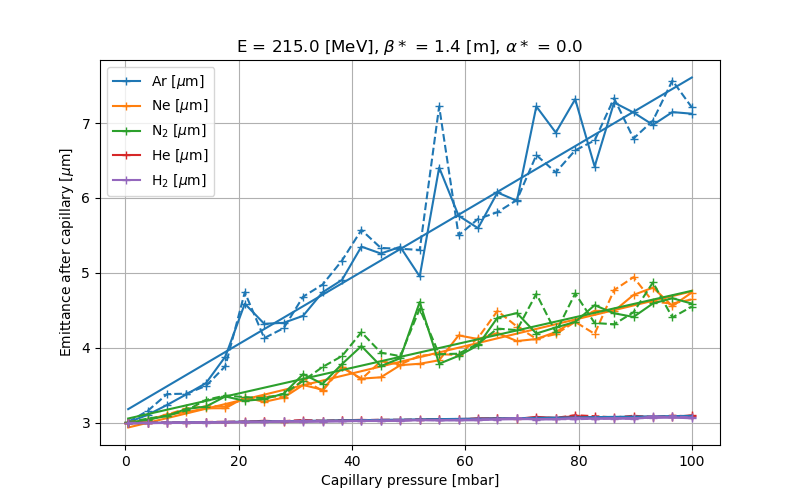

Ar fit:
 eps = 0.04449953430049842*press + 3.15788888289602, R=0.9628947189224614, P=1.1011787154753052e-34, ERR=0.0016376799446464496

Ne fit:
 eps = 0.018265957980837494*press + 2.9258758952084825, R=0.9772905824080352, P=8.790410511660213e-41, ERR=0.0005200474735589289

N2 fit:
 eps = 0.017136827409713246*press + 3.046481850615955, R=0.936566163554366, P=4.33564653726209e-28, ERR=0.0008420824599421357

He fit:
 eps = 0.0009782390306811363*press + 2.992480506228247, R=0.9703919147663682, P=1.753415867864025e-37, ERR=3.197166767452638e-05

H2 fit:
 eps = 0.0007673521433836811*press + 2.9923077456768348, R=0.9615782381954768, P=2.9722537627726333e-34, ERR=2.8766534303131438e-05



In [14]:
plt.figure()
plt.clf()

l_Ar = plt.plot(press, eps_x_Ar, '+-', label=r"Ar [$\mu$m]")[0]
plt.plot(press, eps_y_Ar, '+--', color=l_Ar.get_color())
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(np.concatenate([press,press]),np.concatenate([eps_x_Ar,eps_y_Ar]))
plt.plot(press,intercept+press*slope, color=l_Ar.get_color())
print("Ar fit:\n eps = {}*press + {}, R={}, P={}, ERR={}\n".format(slope,intercept,r_value,p_value,std_err))

l_Ne = plt.plot(press, eps_x_Ne, '+-', label=r"Ne [$\mu$m]")[0]
plt.plot(press, eps_y_Ne, '+--', color=l_Ne.get_color())
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(np.concatenate([press,press]),np.concatenate([eps_x_Ne,eps_y_Ne]))
plt.plot(press,intercept+press*slope, color=l_Ne.get_color())
print("Ne fit:\n eps = {}*press + {}, R={}, P={}, ERR={}\n".format(slope,intercept,r_value,p_value,std_err))

l_N2 = plt.plot(press, eps_x_N2, '+-', label=r"N$_2$ [$\mu$m]")[0]
plt.plot(press, eps_y_N2, '+--', color=l_N2.get_color())
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(np.concatenate([press,press]),np.concatenate([eps_x_N2,eps_y_N2]))
plt.plot(press,intercept+press*slope, color=l_N2.get_color())
print("N2 fit:\n eps = {}*press + {}, R={}, P={}, ERR={}\n".format(slope,intercept,r_value,p_value,std_err))

l_He = plt.plot(press, eps_x_He, '+-', label=r"He [$\mu$m]")[0]
plt.plot(press, eps_y_He, '+--', color=l_He.get_color())
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(np.concatenate([press,press]),np.concatenate([eps_x_He,eps_y_He]))
plt.plot(press,intercept+press*slope, color=l_Ar.get_color())
print("He fit:\n eps = {}*press + {}, R={}, P={}, ERR={}\n".format(slope,intercept,r_value,p_value,std_err))

l_H2 = plt.plot(press, eps_x_H2, '+-', label=r"H$_2$ [$\mu$m]")[0]
plt.plot(press, eps_y_H2, '+--', color=l_H2.get_color())
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(np.concatenate([press,press]),np.concatenate([eps_x_H2,eps_y_H2]))
plt.plot(press,intercept+press*slope, color=l_H2.get_color())
print("H2 fit:\n eps = {}*press + {}, R={}, P={}, ERR={}\n".format(slope,intercept,r_value,p_value,std_err))

plt.xlabel("Capillary pressure [mbar]")
plt.ylabel("Emittance after capillary [$\mu$m]")
plt.title(r"E = {} [MeV], $\beta*$ = {} [m], $\alpha*$ = {}".format(ENERGY, BETA, ALPHA))

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#plt.ylim(2.5,5.5)
#plt.xlim(0.4,60)
#plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid()

plt.legend(loc="upper left")

plt.show()